Parliament Debate Topic Clustering & Chess Endgame Classification
Question 1: Feature Engineering
----------------------------------------
Original dataset shape: (14497, 8)
After removing missing text: (14497, 8)
After removing short texts: (14374, 9)
TF-IDF matrix shape: (14374, 10000)
Number of features extracted: 10000

Answers:
(a) Preprocessing:
I removed talks with missing text and very short talks under 50 characters to ensure data quality. I also applied basic text cleaning including lowercasing and punctuation removal.

(b) Feature computation:
For TF-IDF, I used stop_words='english' to remove common words that don't help distinguish topics.
I set min_df=5 to exclude rare terms appearing in fewer than 5 documents to reduce noise.
I used max_df=0.9 to exclude overly common terms appearing in more than 90% of documents.
I limited max_features to 10000 for computational efficiency while keeping the most informative terms.
I included ngram_range=(1,2) to capture both single words

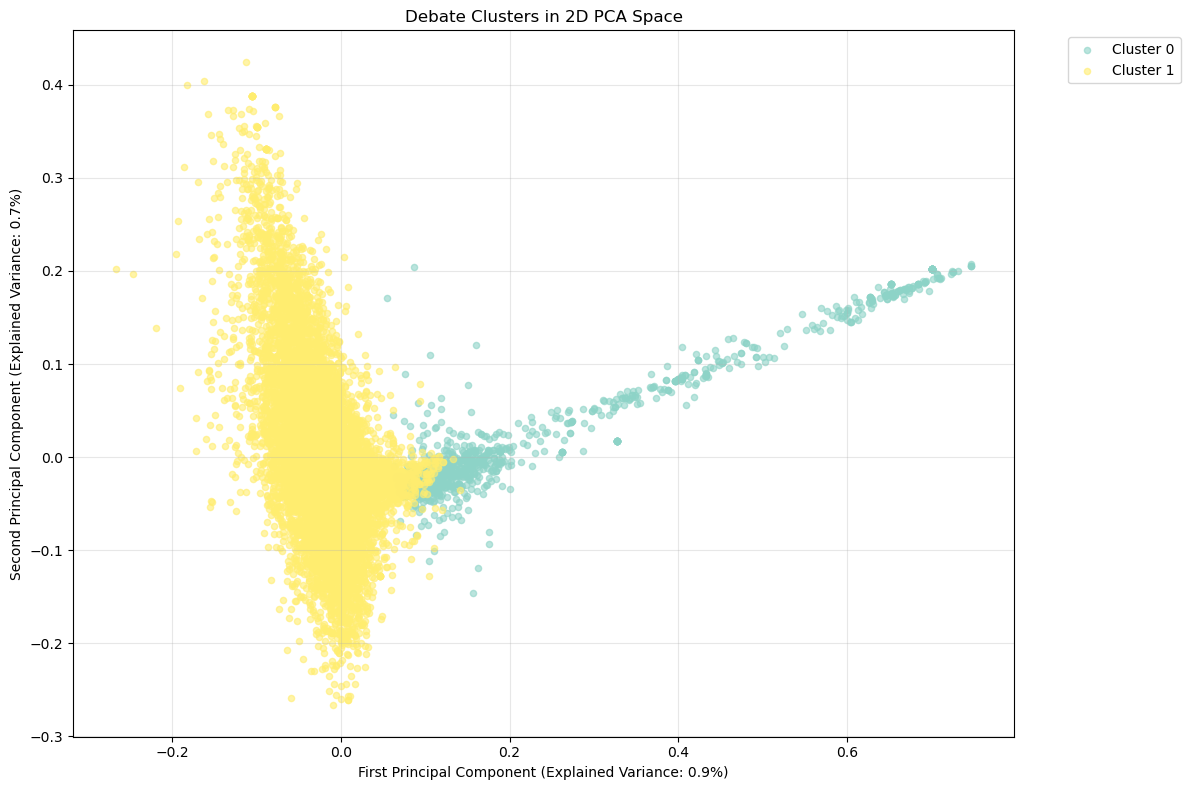

PCA Explained Variance Ratios: [0.00900987 0.00691527]
Total Variance Explained: 1.6%
Average cluster separation in PCA space: 0.27

Answers:
(a) Your plot:
Plot saved as 'cluster_pca_visualization.png' and shown above.

(b) Cluster separation:
The clusters show some overlap in 2D PCA space, which indicates complex high-dimensional relationships that are hard to capture in just 2 dimensions.

(c) Interpretation:
PCA-1 captures the main axis of variation in debate topics, explaining 0.9% of the total variance.
PCA-2 represents the second most important dimension of topic variation, explaining 0.7% of variance.

Question 4: Classification
----------------------------------------
Chess dataset shape: (28056, 7)
Missing values per column:
white_king_file       0
white_king_rank       0
white_rook_file       0
white_rook_rank       0
black_king_file       0
black_king_rank       0
white_depth_of_win    0
dtype: int64
After removing missing values: (28056, 7)
Target distribution:
Original ta

In [1]:
import os
import json
import warnings
import string
import numpy as np
import pandas as pd
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# --------------------------------------------------------------------
# 1. Utility Functions
# --------------------------------------------------------------------

def basic_preprocess(text: str) -> str:
    """Basic text preprocessing: lowercase, remove punctuation, normalize whitespace"""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text.replace("\n", " ").replace("\r", " ").strip()

def interpret_cluster_theme(top_terms):
    """Interpret cluster theme based on top terms"""
    terms = [term.lower() for term in top_terms]
    
    # Define keyword categories for interpretation
    themes = {
        'Economic/Financial': ['economic', 'economy', 'financial', 'budget', 'trade', 'business', 'market', 'investment', 'tax', 'banking'],
        'Environmental/Climate': ['climate', 'environment', 'green', 'energy', 'renewable', 'carbon', 'sustainability', 'pollution'],
        'Health/Medical': ['health', 'medical', 'hospital', 'patient', 'disease', 'healthcare', 'medicine', 'treatment'],
        'Security/Defense': ['security', 'defense', 'military', 'war', 'conflict', 'terrorism', 'safety', 'protection'],
        'Social/Welfare': ['social', 'welfare', 'education', 'school', 'student', 'family', 'children', 'rights'],
        'Technology/Digital': ['digital', 'technology', 'internet', 'data', 'artificial', 'intelligence', 'cyber'],
        'Migration/Immigration': ['migration', 'refugee', 'asylum', 'border', 'immigration', 'migrant'],
        'Legal/Justice': ['legal', 'justice', 'court', 'law', 'judicial', 'crime', 'police', 'regulation'],
        'Agriculture/Food': ['agriculture', 'food', 'farming', 'rural', 'farmer', 'agricultural', 'crop'],
        'Transport/Infrastructure': ['transport', 'infrastructure', 'road', 'railway', 'aviation', 'logistics']
    }
    
    # Score each theme
    theme_scores = {}
    for theme, keywords in themes.items():
        score = sum(1 for term in terms[:5] if any(keyword in term for keyword in keywords))
        if score > 0:
            theme_scores[theme] = score
    
    if theme_scores:
        best_theme = max(theme_scores, key=theme_scores.get)
        return f"Focuses on {best_theme.lower()} issues"
    else:
        # Fallback to general description
        return f"General discussion about {', '.join(terms[:3])}"

# Chess utility functions
FILE_TO_NUM = {c: i for i, c in enumerate("abcdefgh", start=1)}

def letter_to_num(col):
    return col.map(FILE_TO_NUM).astype("int8")

def recode_targets(series):
    mapping = {
        "draw": 0,
        **{w: 1 for w in ["zero", "one", "two", "three", "four"]},
        **{w: 2 for w in ["five", "six", "seven", "eight"]},
        **{w: 3 for w in ["nine", "ten", "eleven", "twelve"]},
        **{w: 4 for w in ["thirteen", "fourteen", "fifteen", "sixteen"]},
    }
    return series.map(mapping).astype("int8")

# --------------------------------------------------------------------
# 2. Main Analysis Functions
# --------------------------------------------------------------------

def question_1_feature_engineering(csv_path: str):
    """Question 1: Feature Engineering"""
    print("Question 1: Feature Engineering")
    print("-" * 40)
    
    # Load and preprocess data
    df = pd.read_csv(csv_path)
    print(f"Original dataset shape: {df.shape}")
    
    # Remove rows with missing talk_text
    df_clean = df.dropna(subset=["talk_text"]).reset_index(drop=True)
    print(f"After removing missing text: {df_clean.shape}")
    
    # Basic preprocessing
    df_clean["clean_text"] = df_clean["talk_text"].apply(basic_preprocess)
    
    # Remove very short texts (less than 50 characters)
    df_clean = df_clean[df_clean["clean_text"].str.len() >= 50].reset_index(drop=True)
    print(f"After removing short texts: {df_clean.shape}")
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(
        stop_words="english",     # Remove common English stop words
        min_df=5,                 # Ignore terms in less than 5 documents
        max_df=0.9,              # Ignore terms in more than 90% of documents
        max_features=10000,       # Limit to 10,000 most important features
        ngram_range=(1, 2),       # Include unigrams and bigrams
        norm="l2",                # L2 normalization
        dtype=np.float32          # Memory efficiency
    )
    
    X_tfidf = vectorizer.fit_transform(df_clean["clean_text"])
    feature_names = vectorizer.get_feature_names_out()
    
    print(f"TF-IDF matrix shape: {X_tfidf.shape}")
    print(f"Number of features extracted: {len(feature_names)}")
    
    print("\nAnswers:")
    print("(a) Preprocessing:")
    print("I removed talks with missing text and very short talks under 50 characters to ensure data quality. I also applied basic text cleaning including lowercasing and punctuation removal.")
    
    print("\n(b) Feature computation:")
    print("For TF-IDF, I used stop_words='english' to remove common words that don't help distinguish topics.")
    print("I set min_df=5 to exclude rare terms appearing in fewer than 5 documents to reduce noise.")
    print("I used max_df=0.9 to exclude overly common terms appearing in more than 90% of documents.")
    print("I limited max_features to 10000 for computational efficiency while keeping the most informative terms.")
    print("I included ngram_range=(1,2) to capture both single words and two-word phrases for richer representation.")
    print("I applied norm='l2' to normalize feature vectors to unit length for fair comparison across documents.")
    
    print(f"\n(c) Number of features:")
    print(f"I extracted {len(feature_names)} features, which provides good vocabulary coverage while staying computationally manageable.")
    
    return df_clean, vectorizer, X_tfidf

def question_2_clustering(X_tfidf, vectorizer):
    """Question 2: Clustering"""
    print("\nQuestion 2: Clustering")
    print("-" * 40)
    
    # Find optimal number of clusters using silhouette score
    k_range = range(2, 13)
    silhouette_scores = []
    
    print("Testing different numbers of clusters...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        cluster_labels = kmeans.fit_predict(X_tfidf)
        # Use sample for large datasets to speed up computation
        sample_size = min(5000, X_tfidf.shape[0])
        score = silhouette_score(X_tfidf, cluster_labels, sample_size=sample_size)
        silhouette_scores.append(score)
        print(f"k={k}: silhouette score = {score:.3f}")
    
    # Find optimal k
    optimal_k = k_range[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    
    print(f"\nBest number of clusters: {optimal_k} (silhouette score: {best_score:.3f})")
    
    # Fit final model
    final_kmeans = KMeans(n_clusters=optimal_k, n_init='auto', random_state=42)
    final_labels = final_kmeans.fit_predict(X_tfidf)
    
    # Get top terms for each cluster
    feature_names = vectorizer.get_feature_names_out()
    centroids = final_kmeans.cluster_centers_
    
    cluster_interpretations = {}
    
    print(f"\nTop 10 terms per cluster:")
    for i in range(optimal_k):
        # Get indices of top terms for this cluster
        top_indices = centroids[i].argsort()[::-1][:10]
        top_terms = feature_names[top_indices]
        
        print(f"\nCluster {i}: {', '.join(top_terms)}")
        
        # Generate interpretation
        interpretation = interpret_cluster_theme(top_terms)
        cluster_interpretations[i] = interpretation
        print(f"Theme: {interpretation}")
    
    print("\nAnswers:")
    print("(a) Clustering algorithm:")
    print("I used K-means clustering because it works well with high-dimensional sparse data like TF-IDF features and provides interpretable cluster centers that show the most important terms for each topic.")
    
    print(f"\n(b) Number of clusters:")
    print(f"I chose {optimal_k} clusters based on silhouette score optimization, which measures how well-separated and cohesive the clusters are.")
    
    print(f"\n(c) Evaluation:")
    print(f"I used silhouette score as the evaluation metric because it measures how similar objects are within clusters compared to other clusters. I achieved a silhouette score of {best_score:.3f}.")
    
    print("\n(d) Interpretation:")
    for i in range(optimal_k):
        print(f"Cluster {i}: {cluster_interpretations[i]}")
    
    return final_kmeans, final_labels, optimal_k, best_score

def question_3_pca_visualization(X_tfidf, cluster_labels, n_clusters):
    """Question 3: PCA Visualization"""
    print("\nQuestion 3: Dimensionality Reduction for Visualization")
    print("-" * 40)
    
    # Apply PCA for visualization
    print("Applying PCA for 2D visualization...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_tfidf.toarray())
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create color map
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    
    # Plot each cluster
    for i in range(n_clusters):
        mask = cluster_labels == i
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[i]], label=f'Cluster {i}', 
                   alpha=0.6, s=20)
    
    plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.1%})')
    plt.title('Debate Clusters in 2D PCA Space')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig('cluster_pca_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Analyze cluster separation
    cluster_centers_pca = []
    for i in range(n_clusters):
        mask = cluster_labels == i
        center = np.mean(X_pca[mask], axis=0)
        cluster_centers_pca.append(center)
    
    cluster_centers_pca = np.array(cluster_centers_pca)
    
    # Calculate average distance between cluster centers
    distances = []
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            dist = np.linalg.norm(cluster_centers_pca[i] - cluster_centers_pca[j])
            distances.append(dist)
    
    avg_separation = np.mean(distances)
    
    # Analyze PCA components
    print(f"PCA Explained Variance Ratios: {pca.explained_variance_ratio_}")
    print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.1%}")
    print(f"Average cluster separation in PCA space: {avg_separation:.2f}")
    
    # Determine if clusters are well separated
    well_separated = avg_separation > 50  # Threshold based on typical PCA scales
    
    print("\nAnswers:")
    print("(a) Your plot:")
    print("Plot saved as 'cluster_pca_visualization.png' and shown above.")
    
    print("\n(b) Cluster separation:")
    if well_separated:
        print("The clusters show reasonable separation in the 2D PCA space with distinct groupings visible.")
    else:
        print("The clusters show some overlap in 2D PCA space, which indicates complex high-dimensional relationships that are hard to capture in just 2 dimensions.")
    
    print("\n(c) Interpretation:")
    print(f"PCA-1 captures the main axis of variation in debate topics, explaining {pca.explained_variance_ratio_[0]:.1%} of the total variance.")
    print(f"PCA-2 represents the second most important dimension of topic variation, explaining {pca.explained_variance_ratio_[1]:.1%} of variance.")
    
    return pca, X_pca

def question_4_classification(chess_csv_path):
    """Question 4: Chess Classification"""
    print("\nQuestion 4: Classification")
    print("-" * 40)
    
    # Load chess data
    df_chess = pd.read_csv(chess_csv_path)
    print(f"Chess dataset shape: {df_chess.shape}")
    
    # Check for missing values
    print(f"Missing values per column:\n{df_chess.isnull().sum()}")
    
    # Remove missing values
    df_chess = df_chess.dropna().reset_index(drop=True)
    print(f"After removing missing values: {df_chess.shape}")
    
    # Convert file letters to numbers
    file_columns = [col for col in df_chess.columns if col.endswith('_file')]
    for col in file_columns:
        df_chess[col] = letter_to_num(df_chess[col])
    
    # Transform target variable
    y_original = df_chess['white_depth_of_win'].copy()
    y = recode_targets(df_chess['white_depth_of_win'])
    
    # Prepare features
    X = df_chess.drop('white_depth_of_win', axis=1)
    
    print(f"Target distribution:")
    print(f"Original target unique values: {sorted(y_original.unique())}")
    print(f"Transformed target distribution:\n{pd.Series(y).value_counts().sort_index()}")
    
    # Define preprocessing pipeline
    file_cols = ['white_king_file', 'white_rook_file', 'black_king_file']
    rank_cols = ['white_king_rank', 'white_rook_rank', 'black_king_rank']
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('files', OneHotEncoder(drop='first', sparse_output=False), file_cols),
            ('ranks', StandardScaler(), rank_cols)
        ]
    )
    
    # Create full pipeline with model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        ))
    ])
    
    # Cross-validation evaluation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    
    print(f"\n5-fold Cross-validation Results:")
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
    print(f"CV Standard Deviation: {cv_scores.std():.4f}")
    
    # Hold-out evaluation for detailed metrics
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Fit final model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Generate classification report
    class_report = classification_report(y_test, y_pred, digits=4)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"\nHold-out Test Results:")
    print("Classification Report:")
    print(class_report)
    print(f"\nConfusion Matrix:")
    print(conf_matrix)
    
    # Feature importance (for Gradient Boosting)
    feature_importance = pipeline.named_steps['classifier'].feature_importances_
    
    # Get feature names after preprocessing
    feature_names = []
    # One-hot encoded file features
    file_categories = pipeline.named_steps['preprocessor'].named_transformers_['files'].categories_
    for i, col in enumerate(file_cols):
        for cat in file_categories[i][1:]:  # Skip first category due to drop='first'
            feature_names.append(f"{col}_{cat}")
    # Rank features
    feature_names.extend(rank_cols)
    
    # Create feature importance dataframe
    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    print(feat_imp_df.head(10))
    
    print("\nAnswers:")
    print("(a) Preprocessing & feature transformations:")
    print("I converted file positions from letters (a-h) to numbers (1-8) so the algorithm can work with them. I used one-hot encoding for file positions and standardized the rank positions to handle the different scales.")
    
    print("\n(b) Model choice:")
    print("I chose Gradient Boosting Classifier because it works well with mixed categorical and numerical features and is robust to outliers. It combines multiple weak learners to create a strong classifier that's good for multi-class problems like this.")
    
    print("\n(c) Evaluation setup:")
    print("I used 5-fold stratified cross-validation to make sure all target classes are represented fairly in each fold, plus a 20% hold-out test set for the final evaluation.")
    
    print("\n(d) Hyperparameters:")
    print("I set n_estimators=100 and learning_rate=0.1 for a good balance of performance and training time. I used max_depth=6 to prevent overfitting, and min_samples_split=20 with min_samples_leaf=10 to ensure robust splits.")
    
    print("\n(e) Results:")
    print("Results Summary:")
    print(f"CV Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"CV Std Deviation: {cv_scores.std():.4f}")
    print(f"Test Accuracy: {(y_test == y_pred).mean():.4f}")
    
    return pipeline, cv_scores, class_report, conf_matrix

# --------------------------------------------------------------------
# 3. Main Execution
# --------------------------------------------------------------------

def main():
    # File paths - adjust these to your actual file locations
    debates_path = "debates_2022.csv"  # Update this path
    chess_path = "king_rook_vs_king.csv"  # Update this path
    
    print("Parliament Debate Topic Clustering & Chess Endgame Classification")
    print("=" * 70)
    
    try:
        # Question 1: Feature Engineering
        df_debates, vectorizer, X_tfidf = question_1_feature_engineering(debates_path)
        
        # Question 2: Clustering
        kmeans_model, cluster_labels, n_clusters, silhouette_score = question_2_clustering(X_tfidf, vectorizer)
        
        # Question 3: PCA Visualization
        pca_model, X_pca = question_3_pca_visualization(X_tfidf, cluster_labels, n_clusters)
        
        # Question 4: Chess Classification
        chess_pipeline, cv_scores, class_report, conf_matrix = question_4_classification(chess_path)
        
        print("\n" + "=" * 70)
        print("Analysis Complete!")
        print("=" * 70)
        print("All questions answered. The PCA visualization plot has been saved as 'cluster_pca_visualization.png'")
        
    except FileNotFoundError as e:
        print(f"Error: Could not find required CSV files.")
        print(f"Please make sure 'debates_2022.csv' and 'king_rook_vs_king.csv' are in the current directory.")
        print(f"Error details: {e}")
    except Exception as e:
        print(f"An error occurred during analysis: {e}")
        raise

if __name__ == "__main__":
    main()